In [23]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


In [24]:
# ============================================================
# HELPER PRINT FUNCTIONS (EĞER TANIMLI DEĞİLSE EKLE)
# ============================================================

def print_separator(title):
    """Print a formatted section separator."""
    print("\n" + "=" * 70)
    print(f" {title}")
    print("=" * 70)


def print_metrics(metrics, title="Results"):
    """Print metrics in a formatted table."""
    print(f"\n{title}:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"  {metric:15s}: {value:.4f}")


In [25]:
class StandardScalerScratch:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [26]:

class GaussianNaiveBayesScratch:
    """
    Gaussian Naive Bayes classifier from scratch.
    - Binary classification (0 / 1) için uygundur.
    """

    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.classes_ = None
        self.means_ = None
        self.vars_ = None
        self.priors_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)

        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.means_ = np.zeros((n_classes, n_features))
        self.vars_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.means_[idx, :] = X_c.mean(axis=0)
            self.vars_[idx, :] = X_c.var(axis=0) + self.var_smoothing
            self.priors_[idx] = X_c.shape[0] / float(n_samples)

        return self

    def _log_gaussian_pdf(self, class_idx, x):
        mean = self.means_[class_idx]
        var = self.vars_[class_idx]
        log_prob = -0.5 * np.log(2.0 * np.pi * var) - ((x - mean) ** 2) / (2.0 * var)
        return log_prob

    def _predict_single_log_posteriors(self, x):
        log_posteriors = []
        for idx, c in enumerate(self.classes_):
            log_prior = np.log(self.priors_[idx])
            log_likelihood = np.sum(self._log_gaussian_pdf(idx, x))
            log_posteriors.append(log_prior + log_likelihood)
        return np.array(log_posteriors)

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        preds = []
        for x in X:
            log_posteriors = self._predict_single_log_posteriors(x)
            preds.append(self.classes_[np.argmax(log_posteriors)])
        return np.array(preds, dtype=int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        all_probs = []
        for x in X:
            log_posteriors = self._predict_single_log_posteriors(x)
            log_posteriors -= np.max(log_posteriors)  # stabilite için
            probs = np.exp(log_posteriors)
            probs /= probs.sum()
            all_probs.append(probs)
        return np.array(all_probs)  # shape: (n_samples, n_classes)


In [27]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, tn, fp, fn


def accuracy_scratch(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix_binary(y_true, y_pred)
    denom = tp + tn + fp + fn
    return (tp + tn) / denom if denom > 0 else 0.0


def precision_scratch(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix_binary(y_true, y_pred)
    denom = tp + fp
    return tp / denom if denom > 0 else 0.0


def recall_scratch(y_true, y_pred):
    tp, tn, fp, fn = confusion_matrix_binary(y_true, y_pred)
    denom = tp + fn
    return tp / denom if denom > 0 else 0.0


def f1_scratch(y_true, y_pred):
    p = precision_scratch(y_true, y_pred)
    r = recall_scratch(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0


def roc_auc_scratch(y_true, y_score):
    """
    Basit ROC-AUC hesaplama (trapezoid kuralı ile).
    y_score: pozitif sınıf (1) olma olasılığı.
    """
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)

    thresholds = np.unique(y_score)
    tpr_list = []
    fpr_list = []

    pos_total = np.sum(y_true == 1)
    neg_total = np.sum(y_true == 0)

    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tp, tn, fp, fn = confusion_matrix_binary(y_true, y_pred)
        tpr = tp / pos_total if pos_total > 0 else 0.0
        fpr = fp / neg_total if neg_total > 0 else 0.0
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    # (0,0) ve (1,1) noktalarını da ekleyelim ki eğri tam otursun
    tpr_list.append(0.0)
    fpr_list.append(0.0)
    tpr_list.append(1.0)
    fpr_list.append(1.0)

    # FPR'e göre sırala
    pairs = sorted(zip(fpr_list, tpr_list))
    fpr_sorted = np.array([p[0] for p in pairs])
    tpr_sorted = np.array([p[1] for p in pairs])

    auc = 0.0
    for i in range(1, len(fpr_sorted)):
        auc += (fpr_sorted[i] - fpr_sorted[i - 1]) * (tpr_sorted[i] + tpr_sorted[i - 1]) / 2.0

    return auc


def all_metrics_scratch(y_true, y_pred, y_proba):
    """
    y_proba: shape (n_samples, n_classes) veya (n_samples,)
    Pozitif sınıf = 1 olduğu varsayımıyla ROC-AUC hesaplar.
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    if y_proba.ndim > 1:
        # sınıf dizisinde pozitif sınıfın index'ini bul
        # ama biz scratch modelde classes_ sıralı (0,1) kabul ediyoruz.
        y_score = y_proba[:, 1]
    else:
        y_score = y_proba

    metrics = {
        "Accuracy": accuracy_scratch(y_true, y_pred),
        "Precision": precision_scratch(y_true, y_pred),
        "Recall": recall_scratch(y_true, y_pred),
        "F1-Score": f1_scratch(y_true, y_pred),
        "ROC-AUC": roc_auc_scratch(y_true, y_score),
    }
    return metrics


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# -----------------------------
# METRİK HESAPLAMA
# -----------------------------
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        if y_proba.ndim > 1:
            pos_proba = y_proba[:, 1]
        else:
            pos_proba = y_proba
        metrics["ROC-AUC"] = roc_auc_score(y_true, pos_proba)
    else:
        metrics["ROC-AUC"] = None
    return metrics


def print_metrics_table(metrics, title="Results"):
    print(f"\n{title}:")
    print("-" * 40)
    for k, v in metrics.items():
        if v is None:
            print(f"{k:12s}: None")
        else:
            print(f"{k:12s}: {v:.4f}")


# -----------------------------
# CONFUSION MATRIX HEATMAP
# -----------------------------
def plot_confusion_matrix_heatmap(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ["0", "1"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()


# -----------------------------
# ROC CURVE
# -----------------------------
def plot_roc_curve_model(y_true, y_proba, title="ROC Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    fpr, tpr, _ = roc_curve(y_true, pos_proba)
    auc = roc_auc_score(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# PRECISION–RECALL CURVE
# -----------------------------
def plot_precision_recall_curve_model(y_true, y_proba, title="Precision-Recall Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    precision, recall, _ = precision_recall_curve(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# METRİK BAR CHART
# -----------------------------
def plot_metrics_bar(metrics, title="Model Performance"):
    names = [k for k in metrics.keys() if metrics[k] is not None]
    values = [metrics[k] for k in names]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(names, values)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.01,
            f"{h:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


In [31]:
def run_gnb_pipeline(X_train_df, X_test_df, y_train_ser, y_test_ser, dataset_name):
    print_separator(f"DATASET: {dataset_name}")
    print(f"Train size: {len(X_train_df)}")
    print(f"Test size : {len(X_test_df)}")

    # pandas -> numpy
    X_train = X_train_df.to_numpy(dtype=float)
    X_test = X_test_df.to_numpy(dtype=float)
    y_train = y_train_ser.to_numpy(dtype=int)
    y_test = y_test_ser.to_numpy(dtype=int)

    # ---------------- Standardization (sadece train'e göre) ----------------
    scaler = StandardScalerScratch()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ======================================================================
    # 1) FROM-SCRATCH GAUSSIAN NB
    # ======================================================================
    print("\n[Scratch] Gaussian Naive Bayes eğitiliyor...")
    my_model = GaussianNaiveBayesScratch()
    my_model.fit(X_train_scaled, y_train)

    y_pred_scratch = my_model.predict(X_test_scaled)
    y_proba_scratch = my_model.predict_proba(X_test_scaled)

    scratch_metrics = all_metrics_scratch(y_test, y_pred_scratch, y_proba_scratch)
    print_metrics(scratch_metrics, title="[Scratch] Test Sonuçları")

    tp, tn, fp, fn = confusion_matrix_binary(y_test, y_pred_scratch)
    print("\n[Scratch] Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 Neg    Pos")
    print(f"  Actual Neg     {tn:3d}    {fp:3d}")
    print(f"  Actual Pos     {fn:3d}    {tp:3d}")

    # ---------------- GRAPHICS FOR SCRATCH MODEL ----------------
    plot_confusion_matrix_heatmap(
        y_test, y_pred_scratch,
        title=f"{dataset_name} - Scratch Gaussian NB Confusion Matrix"
    )
    plot_roc_curve_model(
        y_test, y_proba_scratch,
        title=f"{dataset_name} - Scratch Gaussian NB ROC Curve"
    )
    plot_precision_recall_curve_model(
        y_test, y_proba_scratch,
        title=f"{dataset_name} - Scratch Gaussian NB PR Curve"
    )
    plot_metrics_bar(
        scratch_metrics,
        title=f"{dataset_name} - Scratch Gaussian NB Metrics"
    )

    # ======================================================================
    # 2) SKLEARN GAUSSIAN NB
    # ======================================================================
    print("\n[Sklearn] GaussianNB ile doğrulama (aynı scaling ile)...")

    sk_model = SklearnGaussianNB()
    sk_model.fit(X_train_scaled, y_train)

    sk_pred = sk_model.predict(X_test_scaled)
    sk_proba = sk_model.predict_proba(X_test_scaled)

    sk_metrics = {
        "Accuracy": accuracy_score(y_test, sk_pred),
        "Precision": precision_score(y_test, sk_pred),
        "Recall": recall_score(y_test, sk_pred),
        "F1-Score": f1_score(y_test, sk_pred),
        "ROC-AUC": roc_auc_score(y_test, sk_proba[:, 1]),
    }

    print_metrics(sk_metrics, title="[Sklearn] Test Sonuçları")

    # ---------------- GRAPHICS FOR SKLEARN MODEL ----------------
    plot_confusion_matrix_heatmap(
        y_test, sk_pred,
        title=f"{dataset_name} - Sklearn Gaussian NB Confusion Matrix"
    )
    plot_roc_curve_model(
        y_test, sk_proba,
        title=f"{dataset_name} - Sklearn Gaussian NB ROC Curve"
    )
    plot_precision_recall_curve_model(
        y_test, sk_proba,
        title=f"{dataset_name} - Sklearn Gaussian NB PR Curve"
    )
    plot_metrics_bar(
        sk_metrics,
        title=f"{dataset_name} - Sklearn Gaussian NB Metrics"
    )

    # ======================================================================
    # 3) SCRATCH vs SKLEARN KARŞILAŞTIRMA TABLOSU
    # ======================================================================
    print("\nKarşılaştırma (Scratch vs Sklearn):")
    print("-" * 50)
    print(f"  {'Metric':10s} {'Scratch':>10s} {'Sklearn':>10s} {'Diff':>10s}")
    print("-" * 50)
    for m in scratch_metrics.keys():
        diff = scratch_metrics[m] - sk_metrics[m]
        print(f"  {m:10s} {scratch_metrics[m]:>10.4f} {sk_metrics[m]:>10.4f} {diff:>+10.4f}")

    return scratch_metrics, sk_metrics



 GAUSSIAN NAIVE BAYES (SCRATCH) - TWO HEART DATASETS

 DATASET 1: preprocessed_heart_disease_uci.csv
Dataset 1 shape: (920, 15)
Target distribution:
1    509
0    411
Name: target, dtype: int64

 DATASET: Preprocessed UCI Heart
Train size: 736
Test size : 184

[Scratch] Gaussian Naive Bayes eğitiliyor...

[Scratch] Test Sonuçları:
----------------------------------------
  Accuracy       : 0.8098
  Precision      : 0.8317
  Recall         : 0.8235
  F1-Score       : 0.8276
  ROC-AUC        : 0.8862

[Scratch] Confusion Matrix:
                 Predicted
                 Neg    Pos
  Actual Neg      65     17
  Actual Pos      18     84


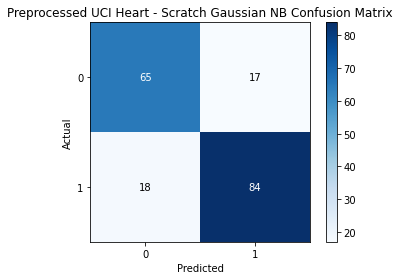

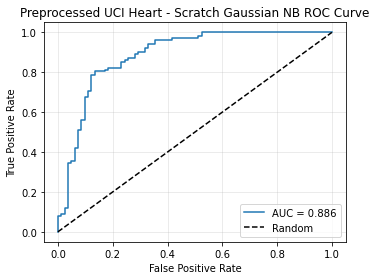

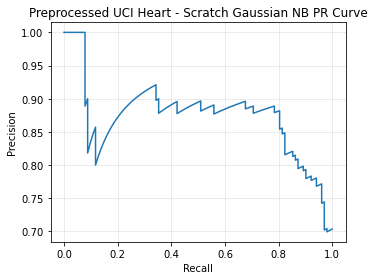

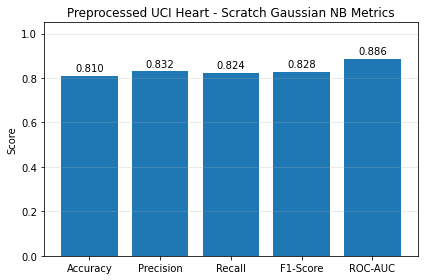


[Sklearn] GaussianNB ile doğrulama (aynı scaling ile)...

[Sklearn] Test Sonuçları:
----------------------------------------
  Accuracy       : 0.8098
  Precision      : 0.8317
  Recall         : 0.8235
  F1-Score       : 0.8276
  ROC-AUC        : 0.8862


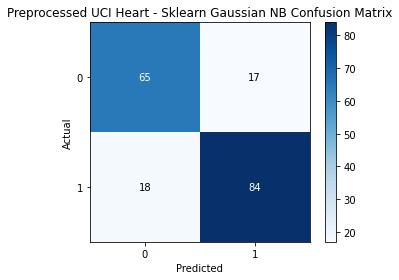

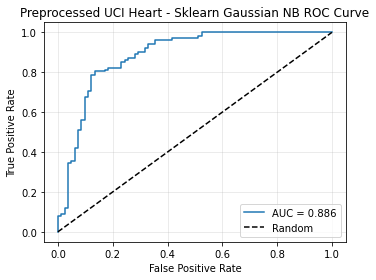

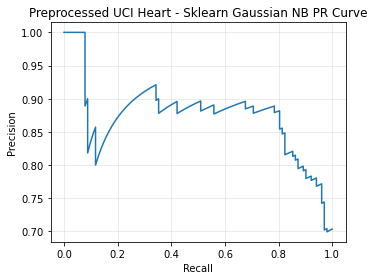

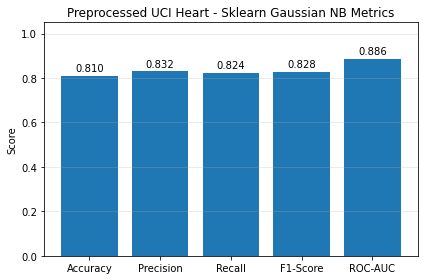


Karşılaştırma (Scratch vs Sklearn):
--------------------------------------------------
  Metric        Scratch    Sklearn       Diff
--------------------------------------------------
  Accuracy       0.8098     0.8098    +0.0000
  Precision      0.8317     0.8317    +0.0000
  Recall         0.8235     0.8235    +0.0000
  F1-Score       0.8276     0.8276    +0.0000
  ROC-AUC        0.8862     0.8862    -0.0000

 DATASET 2: processed_heart.csv
Dataset 2 shape: (918, 16)
Target distribution:
1    508
0    410
Name: HeartDisease, dtype: int64

 DATASET: Processed Heart (Kaggle)
Train size: 734
Test size : 184

[Scratch] Gaussian Naive Bayes eğitiliyor...

[Scratch] Test Sonuçları:
----------------------------------------
  Accuracy       : 0.9130
  Precision      : 0.9300
  Recall         : 0.9118
  F1-Score       : 0.9208
  ROC-AUC        : 0.9451

[Scratch] Confusion Matrix:
                 Predicted
                 Neg    Pos
  Actual Neg      75      7
  Actual Pos       9     93


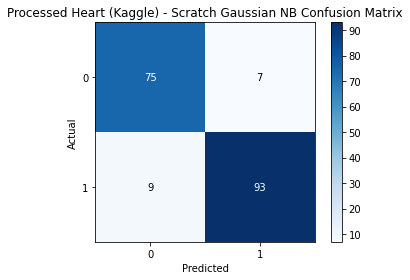

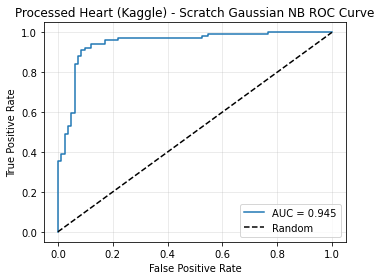

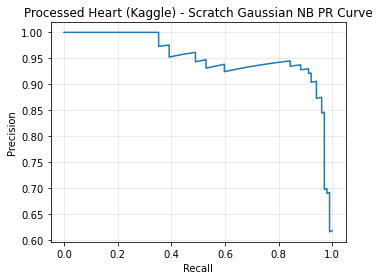

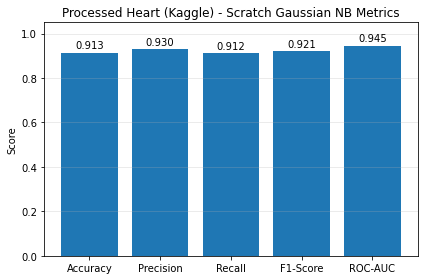


[Sklearn] GaussianNB ile doğrulama (aynı scaling ile)...

[Sklearn] Test Sonuçları:
----------------------------------------
  Accuracy       : 0.9130
  Precision      : 0.9300
  Recall         : 0.9118
  F1-Score       : 0.9208
  ROC-AUC        : 0.9451


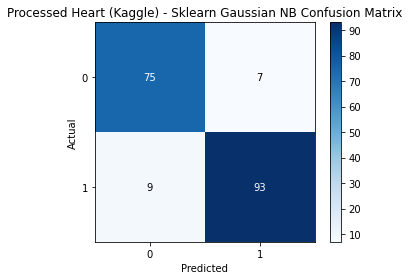

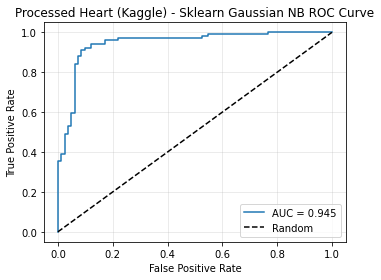

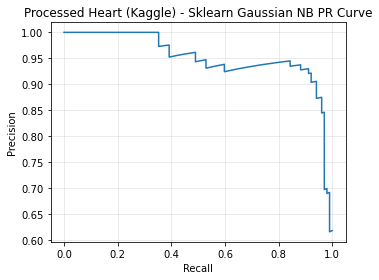

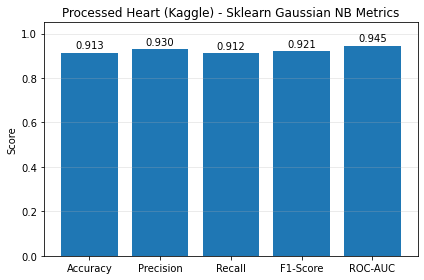


Karşılaştırma (Scratch vs Sklearn):
--------------------------------------------------
  Metric        Scratch    Sklearn       Diff
--------------------------------------------------
  Accuracy       0.9130     0.9130    +0.0000
  Precision      0.9300     0.9300    +0.0000
  Recall         0.9118     0.9118    +0.0000
  F1-Score       0.9208     0.9208    +0.0000
  ROC-AUC        0.9451     0.9451    -0.0000

 FINAL SUMMARY (SCRATCH RESULTS)

Dataset                                  Acc     Prec   Recall       F1      AUC
Preprocessed UCI Heart                0.8098   0.8317   0.8235   0.8276   0.8862
Processed Heart (Kaggle)              0.9130   0.9300   0.9118   0.9208   0.9451


In [32]:

def main():
    print_separator("GAUSSIAN NAIVE BAYES (SCRATCH) - TWO HEART DATASETS")

    # ---------------- 1) preprocessed_heart_disease_uci.csv ----------------
    print_separator("DATASET 1: preprocessed_heart_disease_uci.csv")
    df1 = pd.read_csv("preprocessed_heart_disease_uci.csv")
    X1 = df1.drop("target", axis=1)
    y1 = df1["target"]

    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, y1, test_size=0.2, random_state=42, stratify=y1
    )

    print("Dataset 1 shape:", df1.shape)
    print("Target distribution:")
    print(y1.value_counts())

    res1_scratch, res1_sk = run_gnb_pipeline(
        X1_train, X1_test, y1_train, y1_test,
        dataset_name="Preprocessed UCI Heart"
    )

    # ---------------- 2) processed_heart.csv ----------------
    print_separator("DATASET 2: processed_heart.csv")
    df2 = pd.read_csv("processed_heart.csv")
    X2 = df2.drop("HeartDisease", axis=1)
    y2 = df2["HeartDisease"]

    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=42, stratify=y2
    )

    print("Dataset 2 shape:", df2.shape)
    print("Target distribution:")
    print(y2.value_counts())

    res2_scratch, res2_sk = run_gnb_pipeline(
        X2_train, X2_test, y2_train, y2_test,
        dataset_name="Processed Heart (Kaggle)"
    )

    # ---------------- ÖZET TABLO ----------------
    print_separator("FINAL SUMMARY (SCRATCH RESULTS)")

    print("\n" + "=" * 80)
    print(f"{'Dataset':<35} {'Acc':>8} {'Prec':>8} {'Recall':>8} {'F1':>8} {'AUC':>8}")
    print("=" * 80)

    for name, m in [
        ("Preprocessed UCI Heart", res1_scratch),
        ("Processed Heart (Kaggle)", res2_scratch),
    ]:
        print(
            f"{name:<35} "
            f"{m['Accuracy']:>8.4f} "
            f"{m['Precision']:>8.4f} "
            f"{m['Recall']:>8.4f} "
            f"{m['F1-Score']:>8.4f} "
            f"{m['ROC-AUC']:>8.4f}"
        )

    print("=" * 80)


if __name__ == "__main__":
    main()